# Time for Tea - mulitple sites

An exploratory notebook for the above project where we combine kettle use data from multiple sites and try to predict a site not included in the model.

Messy and only limited commmentary.


## Get Data and Combine

In [4]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Loop over all data files
 - Read in a data file
 - Pre-process
 - Apply transforms
 - Concatonate

In [70]:
input_dict = [
              {"file": "CLEAN_House3.csv", "kettle_col": "Appliance9"},
              {"file": "CLEAN_House4.csv", "kettle_col": "Appliance9"},
              {"file": "CLEAN_House5.csv", "kettle_col": "Appliance8"},
              {"file": "CLEAN_House6.csv", "kettle_col": "Appliance7"},
              {"file": "CLEAN_House7.csv", "kettle_col": "Appliance9"},
              {"file": "CLEAN_House8.csv", "kettle_col": "Appliance9"},
              {"file": "CLEAN_House9.csv", "kettle_col": "Appliance7"},
              {"file": "CLEAN_House11.csv", "kettle_col": "Appliance7"},
              {"file": "CLEAN_House12.csv", "kettle_col": "Appliance6"},
              {"file": "CLEAN_House13.csv", "kettle_col": "Appliance9"},
              {"file": "CLEAN_House17.csv", "kettle_col": "Appliance8"},
              {"file": "CLEAN_House19.csv", "kettle_col": "Appliance5"},
             ]


# Keep as test sets
input_dict_1 = [{"file": "CLEAN_House2.csv", "kettle_col": "Appliance8"}]
input_dict_2 = [{"file": "CLEAN_House20.csv", "kettle_col": "Appliance9"}]
input_dict_3 = [{"file": "CLEAN_House21.csv", "kettle_col": "Appliance7"}]

In [45]:
def pre_process_data(DATA_PATH, input_dict):
    
    file = input_dict['file']
    kettle_col = input_dict['kettle_col']
    
    print(f"PROCESSING FILE: {file}")
    
    df = pd.read_csv(os.path.join(DATA_PATH, file), parse_dates=True, index_col="Time")
    
    cols = ["Aggregate", kettle_col, "Issues"]
    df = df[cols].rename(columns = {"Aggregate" : "total", kettle_col: "kettle"})
    
    
    print(f'Has duplicates?: {df.index.has_duplicates}')
    print(f"start date: {df.index.min()}")
    print(f"end data: {df.index.max()}")

    ideal_days = len(pd.date_range(start=df.index.min(), end=df.index.max(), freq='1D'))
    actual_days = len(np.unique(df.index.date))
    print(f"total_days (inc partial): {actual_days}")
    print(f"missing days (minimum, may be other partial days missing): {ideal_days - actual_days}")

    df.sort_index(axis=0, ascending=True, inplace=True)

    return df

In [34]:
def calc_agg_stats(data):
    return data.min(), data.max(), data.mean(), abs(data.diff()).max()

In [35]:
# Identify rows tagged as issue rows
# Assume resampled row is an issue row if > threshold of entries in period marked as issue

def calc_issue_bools(data, threshold=0.1):
    return ((sum(data > 0) / max(1, len(data))) > threshold) * 1

In [36]:
# Try two versions of kettle labeling

# if kettle is active for any period tag resampled row as kettle active
def calc_kettle_bools_any(data):
    return (data > 0).any()*1

# if kettle is active for more than threshold of entries tag resampled row as kettle active
def calc_kettle_bools_threshold(data, threshold=0.25):
    return ((sum(data > 0) / max(1, len(data))) > threshold) * 1

In [47]:
def resample_df(df_in, period='300s'):
    
    tot_energy_resampled = df_in[["total"]].resample('300s').apply(calc_agg_stats)
    df_energy = pd.DataFrame(tot_energy_resampled.total.tolist(), 
                                columns = ['min', 'max', 'mean', 'diff'],
                                index = tot_energy_resampled.index)
    
#     kettle_resampled_any = df_in[["kettle"]].resample('300s').apply(
#         calc_kettle_bools_any).rename(columns = {"kettle": "kettle_any"})
    
    kettle_resampled_threshold = df_in[["kettle"]].resample('300s').apply(
        calc_kettle_bools_threshold).rename(columns = {"kettle": "kettle_thresh"})
    
    issues_resampled = df_in[["Issues"]].resample('300s').apply(calc_issue_bools)
    
    df_out = pd.concat([df_energy, kettle_resampled_threshold, 
                    issues_resampled], axis=1)
    
    return df_out

In [38]:
def drop_nans_and_issue_rows(df):
    
    df.drop(df[df.Issues > 0].index, inplace=True)
    df.drop(["Issues"], axis=1, inplace=True)
    df.drop(df[df.isnull().any(axis=1)].index, inplace=True)
    
    return df

In [41]:
# This does everything
def process_data(DATA_PATH, input_dict):
    
    df_in = pre_process_data(DATA_PATH, input_dict)
    df = resample_df(df_in, period='300s')
    df_out = drop_nans_and_issue_rows(df)
    
    return(df_out)

In [50]:
df_processed = pd.DataFrame()

for item in input_dict:
    df_out = process_data(DATA_PATH, item)
    df_processed = pd.concat([df_processed, df_out])
df_processed

PROCESSING FILE: CLEAN_House3.csv
Has duplicates?: False
start date: 2013-09-25 19:21:09
end data: 2015-06-02 10:55:42
total_days (inc partial): 562
missing days (minimum, may be other partial days missing): 53
PROCESSING FILE: CLEAN_House4.csv
Has duplicates?: False
start date: 2013-10-11 10:19:17
end data: 2015-07-07 09:57:38
total_days (inc partial): 594
missing days (minimum, may be other partial days missing): 40
PROCESSING FILE: CLEAN_House5.csv
Has duplicates?: False
start date: 2013-09-26 09:56:09
end data: 2015-07-06 17:48:55
total_days (inc partial): 628
missing days (minimum, may be other partial days missing): 21
PROCESSING FILE: CLEAN_House6.csv
Has duplicates?: False
start date: 2013-11-28 12:15:35
end data: 2015-06-28 22:14:45
total_days (inc partial): 509
missing days (minimum, may be other partial days missing): 69
PROCESSING FILE: CLEAN_House7.csv
Has duplicates?: False
start date: 2013-11-01 22:01:18
end data: 2015-07-08 02:10:54
total_days (inc partial): 554
missing

,min,max,mean,diff,kettle_thresh
Time,,,,,
2013-09-25 19:20:00,317.0,388.0,335.000000,64.0,0
2013-09-25 19:25:00,319.0,333.0,324.666667,14.0,0
2013-09-25 19:30:00,323.0,334.0,325.555556,8.0,0
2013-09-25 19:35:00,318.0,392.0,326.428571,74.0,0
2013-09-25 19:40:00,390.0,499.0,448.020000,104.0,0
...,...,...,...,...,...
2015-06-20 03:10:00,205.0,273.0,212.422222,61.0,0
2015-06-20 03:15:00,230.0,240.0,233.386364,7.0,0
2015-06-20 03:20:00,221.0,233.0,226.222222,7.0,0


In [53]:
df_processed.to_csv("processed_houses_3_9and11_13and17and19.csv")

## ML Starts Here

In [117]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [55]:
filename = "processed_houses_3_9and11_13and17and19.csv"

train_set = pd.read_csv(filename, parse_dates=[0])

X = train_set.copy().drop(columns = ["kettle_thresh"])
y = train_set["kettle_thresh"].reset_index(drop=True)

### Transformers

In [59]:
class CatFeaturesAdder(BaseEstimator, TransformerMixin):
    """Custom class to work with scikit-learn pipelines etc"""
    
    def __init__(self, add_weekday=True, add_daytime=True): 
        self.add_weekday = add_weekday
        self.add_daytime = add_daytime
    
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        
        if self.add_weekday:
            day_of_week = X.Time.dt.dayofweek
            week_day = (day_of_week < 5) * 1
            X["week_day"] = week_day
            
        if self.add_daytime: # I may have deleted something from here by mistake
            hour_of_day = X.Time.dt.hour
            daytime = ((hour_of_day > 6) & (hour_of_day < 23)) * 1
            X["daytime"] = daytime
            
        return X.drop('Time', axis=1)
    


In [60]:
class NumFeaturesAdder(BaseEstimator, TransformerMixin):
    """Custom class to work with scikit-learn pipelines etc"""
    
    def __init__(self, add_max_min=True): 
        self.add_max_min = add_max_min
    
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
            
        if self.add_max_min:
            max_min = pd.DataFrame(abs(X["max"] - X["min"]))
            X["max_min"] = max_min
            
        return X
            

In [124]:
class Scaler(BaseEstimator, TransformerMixin):
    """Wrapper around the StandardScalar class to allow us to specify cols
    in the pipeline"""
    
    def __init__(self, scaler_type="standard",
                 scale_atribs=['min', 'max', 'mean', 'diff', 'max_min']):
        
        if scaler_type == "standard":
            self.sc = StandardScaler()
        elif scaler_type == "min_max":
            self.sc = MinMaxScaler()
        else:
            raise(ValueError)
            
        self.scale_atribs = scale_atribs
    
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        
        X[self.scale_atribs] = self.sc.fit_transform(X[self.scale_atribs])
        return X

In [126]:
# create transofrmation pipeline
# standard scaler works better than max-min scaler as it tends to bunch data around zero

trans_pipeline = Pipeline([('cat_feat_adder', CatFeaturesAdder(add_weekday=True,
                                                               add_daytime=True)),
                           ('num_feat_adder', NumFeaturesAdder(add_max_min=True)),
                           ('scaler', Scaler(
                               scale_atribs=['min', 'max', 'mean', 'diff', 'max_min'],
                               scaler_type='min_max'))])

In [127]:
# pass a copy of the data to not overwrite original
X1 = pd.DataFrame(data = trans_pipeline.fit_transform(X.copy()))
X1.head()

,min,max,mean,diff,week_day,daytime,max_min
0,0.009297,0.005686,0.009825,0.000940,1,1,0.001043
1,0.009356,0.004880,0.009522,0.000206,1,1,0.000206
2,0.009473,0.004895,0.009548,0.000118,1,1,0.000162
3,0.009327,0.005745,0.009574,0.001087,1,1,0.001087
4,0.011438,0.007313,0.013140,0.001528,1,1,0.001601


In [128]:
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

In [129]:
cols = ['min', 'max', 'mean', 'diff', 'max_min', 'week_day', 'daytime']

In [130]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X1[cols], y)

RandomForestClassifier()

In [71]:
# Get a test set

df_processed_test = pd.DataFrame()

for item in input_dict_1:
    df_out = process_data(DATA_PATH, item)
    df_processed_test = pd.concat([df_processed_test, df_out])
df_processed_test

PROCESSING FILE: CLEAN_House2.csv
Has duplicates?: False
start date: 2013-09-17 22:08:11
end data: 2015-05-28 08:05:43
total_days (inc partial): 491
missing days (minimum, may be other partial days missing): 127


,min,max,mean,diff,kettle_thresh
Time,,,,,
2013-09-17 22:05:00,243.0,703.0,670.058824,451.0,0
2013-09-17 22:10:00,683.0,820.0,729.733333,117.0,0
2013-09-17 22:15:00,680.0,820.0,718.940000,125.0,0
2013-09-17 22:20:00,251.0,819.0,621.120000,324.0,0
2013-09-17 22:25:00,117.0,252.0,166.740000,110.0,0
...,...,...,...,...,...
2015-05-28 07:45:00,235.0,404.0,283.577778,106.0,0
2015-05-28 07:50:00,326.0,10168.0,8720.195652,9630.0,0
2015-05-28 07:55:00,299.0,10144.0,6656.659091,9368.0,0


In [75]:
df_processed_test.loc[:, "Time"] = df_processed_test.index
df_processed_test

,min,max,mean,diff,kettle_thresh,Time
Time,,,,,,
2013-09-17 22:05:00,243.0,703.0,670.058824,451.0,0,2013-09-17 22:05:00
2013-09-17 22:10:00,683.0,820.0,729.733333,117.0,0,2013-09-17 22:10:00
2013-09-17 22:15:00,680.0,820.0,718.940000,125.0,0,2013-09-17 22:15:00
2013-09-17 22:20:00,251.0,819.0,621.120000,324.0,0,2013-09-17 22:20:00
2013-09-17 22:25:00,117.0,252.0,166.740000,110.0,0,2013-09-17 22:25:00
...,...,...,...,...,...,...
2015-05-28 07:45:00,235.0,404.0,283.577778,106.0,0,2015-05-28 07:45:00
2015-05-28 07:50:00,326.0,10168.0,8720.195652,9630.0,0,2015-05-28 07:50:00
2015-05-28 07:55:00,299.0,10144.0,6656.659091,9368.0,0,2015-05-28 07:55:00


In [89]:
X_test = df_processed_test.copy().drop(columns = ["kettle_thresh"]).reset_index(drop=True)
y_test = df_processed_test["kettle_thresh"].reset_index(drop=True)

In [131]:
X1_test = pd.DataFrame(data = trans_pipeline.fit_transform(X_test.copy()))

In [133]:
# Make predictions on test set
y_test_pred_RF = rf_clf.predict(X1_test[cols])

In [104]:
# Make self-predictions on train set - NOT FOR TESTING
y_self_pred_RF = rf_clf.predict(X1[cols])

In [101]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict

In [102]:
def get_true_false_metrics(pred, actual):
    
    TP = len(pred[(pred == 1) & (actual == 1)])
    TN = len(pred[(pred == 0) & (actual == 0)])
    FP = len(pred[(pred == 1) & (actual == 0)])
    FN = len(pred[(pred == 0) & (actual == 1)])

    print(TP, TN, FP, FN)
    
    return TP, TN, FP, FN

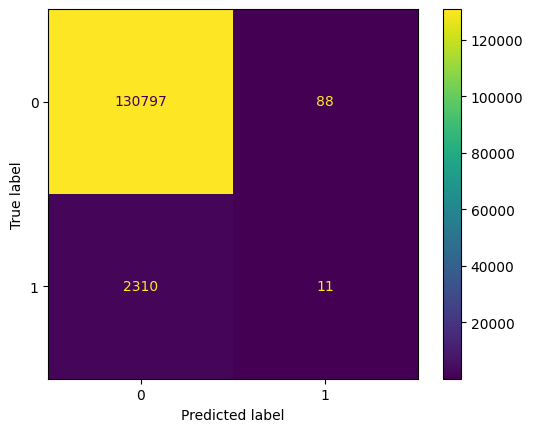

In [103]:
confusion = confusion_matrix(y_test, y_test_pred_RF)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion)

disp.plot()
plt.show()

Looks like we can't generalise to other sites at present. Quick check of self-predict - i.e predict applied to training set in case something wen wrong there.

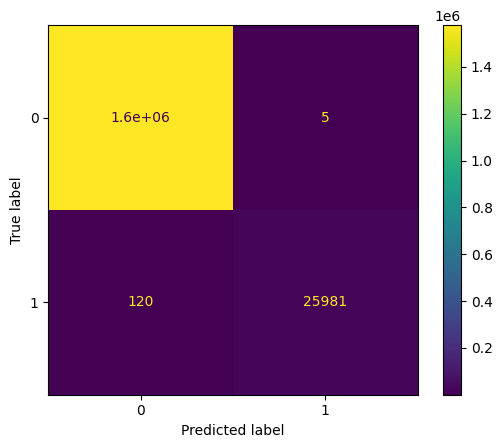

In [105]:
confusion = confusion_matrix(y, y_self_pred_RF)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion)

disp.plot()
plt.show()

This looks fine so the problem is entirely with generalisation

In [ ]:
# Pred on test set using min-max scaling for train and test set rather than standard-scaler

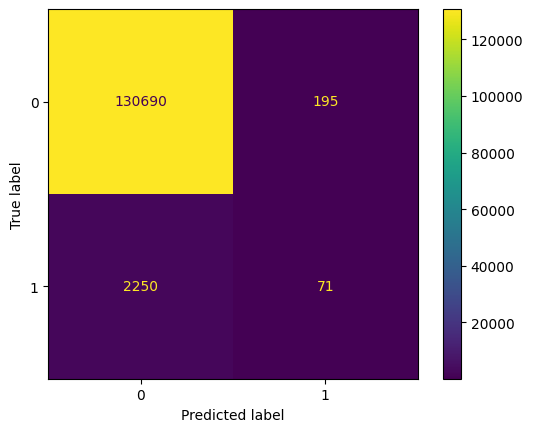

In [135]:
confusion = confusion_matrix(y_test, y_test_pred_RF)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion)

disp.plot()
plt.show()

A tiny bit better but clearly not generalising - back to the drawing board!